# 1. Import Libs & Load datasets

In [1]:
# Author: Liang Jingyu

In [149]:
# Import Libs & Load datasets
import pandas as pd
import numpy as np
import scipy.stats as stats
# import seaborn as sns
from imblearn.over_sampling import SMOTE
from genetic_selection import GeneticSelectionCV

#For Visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go

# Import regression and error metrics modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

import sklearn
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
# Importing time series split for cross validation 
from sklearn.model_selection import train_test_split,TimeSeriesSplit
# Standard scaler for preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

### Try for feature selection

In [150]:
# corr_matrix=data_norm.corr().abs()
# upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
# to_drop=[column for column in upper_triangle.columns if any(upper_triangle[column]>0.80)]
# data_select1=data_norm.drop(to_drop, axis=1)


# selector=VarianceThreshold(0)
# selector.fit(data_select1)
# selected_features=selector.get_support(indices=True)
# selected_column_names=data_select1.columns[selected_features].tolist()
# data_select2=data_select1[selected_column_names]

# 2. Defining Basic Functions

In [152]:
# Creating an empty dict to save all the erros from different models
dict_error = dict()

#计算SMAE
def smae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [153]:
# Plotting predicted vs actual 
def plot_predvstrue_reg(pred, truth, model_name=None):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.scatter(truth, pred) 
    _ = plt.xlabel("Observed  Ventilation Duration")
    _ = plt.ylabel("Predicted Ventilation Duration")
    _ = plt.title("Observed vs Predicted using model {}".format(model_name))
    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    _ = ax.plot(x, x)

In [169]:
def error_metrics(y_pred, y_truth, model_name = None, test = True):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error), MAPE (mean absolute % error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    test: if validating on test set, True; otherwise False for training set validation
    
    The function will print the RMSE, R2, MAE and MAPE error metrics for the model_name and also store the results along with 
    model_name in the dictionary dict_error so that we can compare all the models at the end.
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    print('SMAE or Symmetric Mean Absolute Error: %.2f' % smae(y_truth, y_pred))
    
    MSE = mean_squared_error(y_truth, y_pred)
    print("MSE or Mean squared error: %.2f" % MSE)
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('R2 score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    # Appending the error values along with the model_name to the dict
    if test:
        train_test = 'test'
    else:
        train_test = 'train'
    
    #df = pd.DataFrame({'model': model_name, 'RMSE':RMSE, 'R2':R2, 'MAE':MAE, 'MAPE':MAPE}, index=[0])
    name_error = ['model', 'train_test', 'RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [model_name, train_test, RMSE, R2, MAE, MAPE]
    list_error = list(zip(name_error, value_error))
    
    for error in list_error:
        if error[0] in dict_error:
            # append the new number to the existing array at this slot
            dict_error[error[0]].append(error[1])
        else:
            # create a new array in this slot
            dict_error[error[0]] = [error[1]]
    #return(dict_error)

In [157]:
def train_test(data, test_size = 0.15, scale = False, cols_to_transform=None, include_test_scale=False):
#         - scale: if True, then the columns in the -'cols_to_transform'- list will be scaled using StandardScaler
#         - include_test_scale: If True, the StandardScaler fits the data on the training as well as the test set; if False, then
#           the StandardScaler fits only on the training set.

    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale and include_test_scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('vent_duration', axis = 1).iloc[:test_index]
    y_train = df.vent_duration.iloc[:test_index]
    X_test = df.drop('vent_duration', axis = 1).iloc[test_index:]
    y_test = df.vent_duration.iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

# 2. Read Files & Data Analysis

In [158]:
#2023.4
# Import Libs & Load datasets
import pandas as pd
import pprint
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv('./sph_2/2Step_1Line.csv')
print(df.shape)

(1923, 27)


In [159]:
df.columns

Index(['Unnamed: 0', 'vent_duration', 'stay_id', 'calcium_48', 'creatinine_48',
       'glucose_48', 'sodium_48', 'chloride_48', 'hemoglobin_48', 'wbc_48',
       'alt_48', 'ast_48', 'alp_48', 'bilirubin_total_48', 'pt_48',
       'calcium_24', 'creatinine_24', 'glucose_24', 'sodium_24', 'chloride_24',
       'hemoglobin_24', 'wbc_24', 'alt_24', 'ast_24', 'alp_24',
       'bilirubin_total_24', 'pt_24'],
      dtype='object')

## Columns to be set as Features !!!

In [160]:
features = ['calcium', 'creatinine','glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc', 'alt', 'ast','alp', 'bilirubin_total', 'pt']
ft_1line_3step = ['calcium-48', 'creatinine-48','glucose-48', 'sodium-48', 'chloride-48', 'hemoglobin-48', 'wbc-48','alt-48', 'ast-48', 'alp-48', 'bilirubin_total-48', 'pt-48','calcium-24', 'creatinine-24', 'glucose-24', 'sodium-24', 'chloride-24','hemoglobin-24', 'wbc-24', 'alt-24', 'ast-24', 'alp-24','bilirubin_total-24', 'pt-24', 'calcium+24', 'creatinine+24','glucose+24', 'sodium+24', 'chloride+24', 'hemoglobin+24', 'wbc+24','alt+24', 'ast+24', 'alp+24', 'bilirubin_total+24', 'pt+24']
ft_1line_2step = ['calcium_48', 'creatinine_48','glucose_48', 'sodium_48', 'chloride_48', 'hemoglobin_48', 'wbc_48','alt_48', 'ast_48', 'alp_48', 'bilirubin_total_48', 'pt_48','calcium_24', 'creatinine_24', 'glucose_24', 'sodium_24', 'chloride_24','hemoglobin_24', 'wbc_24', 'alt_24', 'ast_24', 'alp_24','bilirubin_total_24', 'pt_24']
y_col = 'vent_duration'

# Regression Models

In [161]:
demo = df.copy()
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1923 entries, 0 to 1922
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1923 non-null   int64  
 1   vent_duration       1923 non-null   float64
 2   stay_id             1923 non-null   int64  
 3   calcium_48          1923 non-null   float64
 4   creatinine_48       1923 non-null   float64
 5   glucose_48          1923 non-null   float64
 6   sodium_48           1923 non-null   float64
 7   chloride_48         1923 non-null   float64
 8   hemoglobin_48       1923 non-null   float64
 9   wbc_48              1923 non-null   float64
 10  alt_48              1923 non-null   float64
 11  ast_48              1923 non-null   float64
 12  alp_48              1923 non-null   float64
 13  bilirubin_total_48  1923 non-null   float64
 14  pt_48               1923 non-null   float64
 15  calcium_24          1923 non-null   float64
 16  creati

### OLS

In [162]:
x_str ='''calcium_48 + creatinine_48 + glucose_48 + sodium_48 + chloride_48 + hemoglobin_48 + wbc_48 + alt_48 + ast_48 + alp_48
        + bilirubin_total_48 + pt_48 + calcium_24 + creatinine_24 + glucose_24 + sodium_24 + chloride_24 + hemoglobin_24
        + wbc_24 + alt_24 + ast_24 + alp_24 + bilirubin_total_24 + pt_24'''

In [165]:
# Checking linear regression fit using statsmodels Linear regression
from statsmodels.formula.api import ols

df1 = pd.get_dummies(demo, drop_first = True)
x = df1[ft_1line_2step]
y = df1['vent_duration']
ols_m = ols('vent_duration ~ '+ x_str, df1).fit()
print(ols_m.summary())

                            OLS Regression Results                            
Dep. Variable:          vent_duration   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     4.485
Date:                Wed, 12 Apr 2023   Prob (F-statistic):           3.68e-12
Time:                        18:53:29   Log-Likelihood:                -10358.
No. Observations:                1923   AIC:                         2.077e+04
Df Residuals:                    1898   BIC:                         2.090e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            105.1153     36

In [170]:
error_metrics(ols_m.predict(x), y, model_name = 'OLS', test = False)


Error metrics for model OLS
SMAE or Symmetric Mean Absolute Error: 39.83
MSE or Mean squared error: 2791.70
RMSE or Root mean squared error: 52.84
R2 score: 0.05
Mean Absolute Error: 30.33
Mean Absolute Percentage Error: 544.59 %


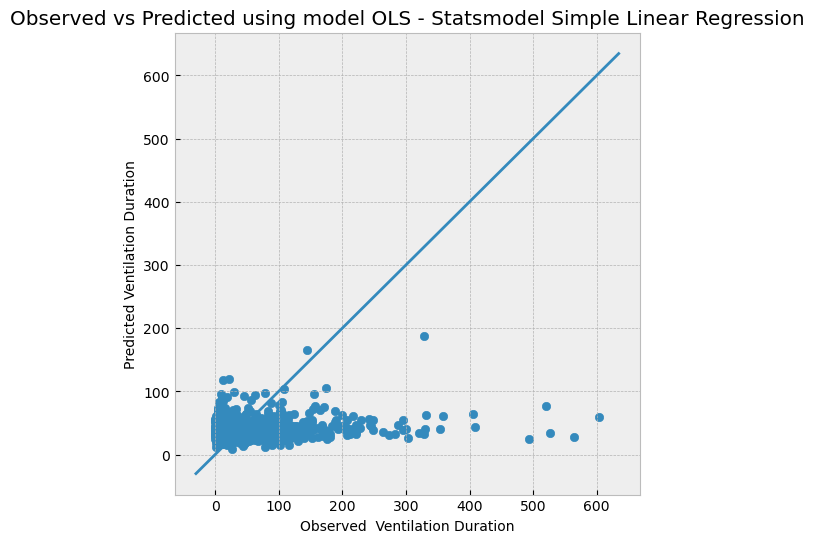

In [122]:
plot_predvstrue_reg(ols_m.fittedvalues, demo.vent_duration, model_name = 'OLS - Statsmodel Simple Linear Regression')

## Linear Regression

In [171]:
# demo.drop['interval_tag','stay_id'] # TBC
demo_lin = pd.get_dummies(demo, drop_first = True)
demo_lin.drop(['stay_id'], axis = 1, inplace = True)
# print(f'Demo Before Get Dummies:\n{demo.head(3)}\n')
# print(f'Demo After  Get Dummies:\n{demo_lin.head(3)}')

In [172]:
from sklearn.linear_model import LinearRegression

x = demo_lin[ft_1line_2step]
y = demo_lin['vent_duration']
X_train, X_test, y_train, y_test = train_test(demo_lin, test_size = 0.2,scale = True, cols_to_transform=ft_1line_2step, 
                                              include_test_scale=True)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

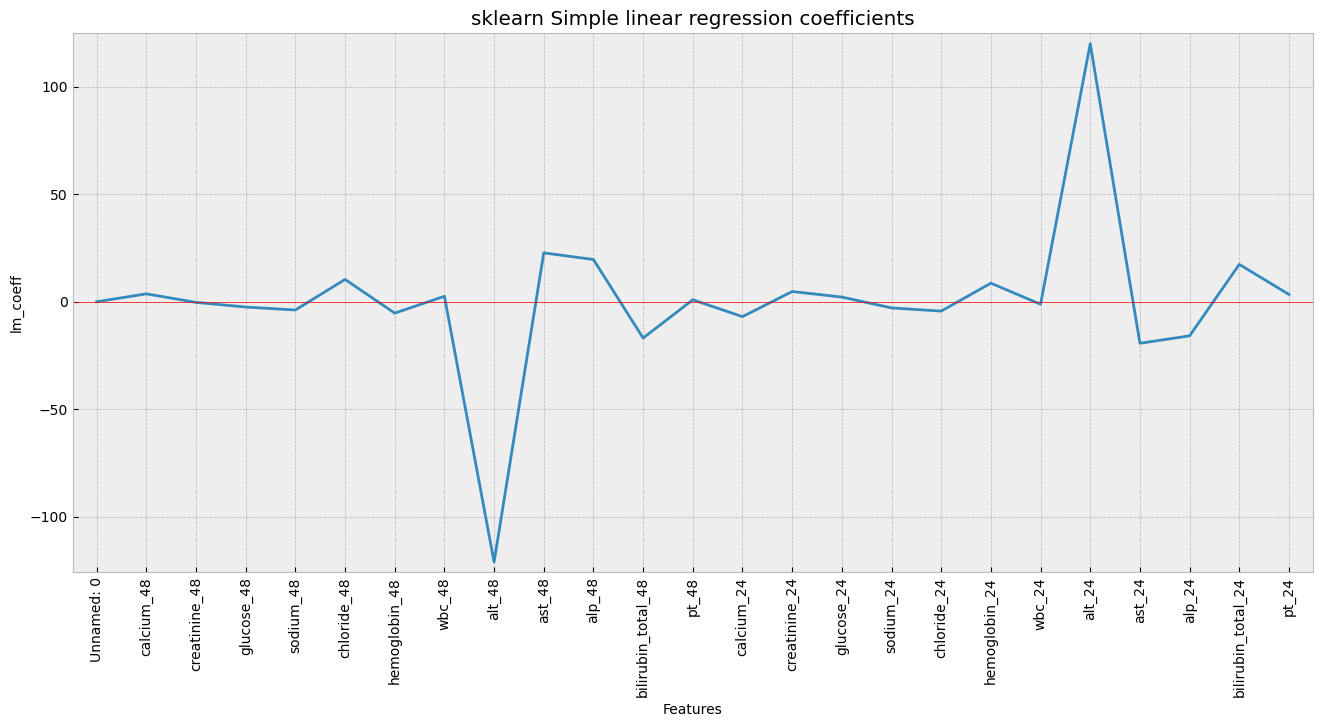

In [173]:
lr.fit(X_train, y_train)
# Plotting the coefficients to check the importance of each coefficient 

# Plot the coefficients
_ = plt.figure(figsize = (16, 7))
_ = plt.plot(range(len(X_train.columns)), lr.coef_)
_ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('sklearn Simple linear regression coefficients')
_ = plt.ylabel('lm_coeff')
_ = plt.xlabel('Features')

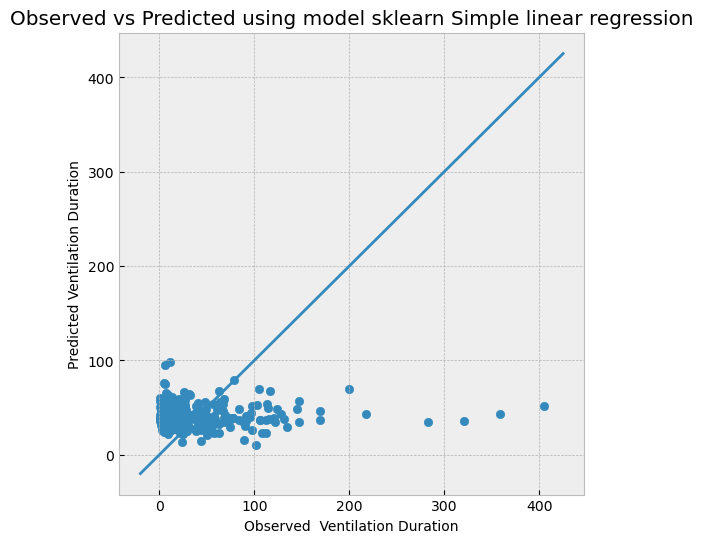

In [174]:
plot_predvstrue_reg(lr.predict(X_test), y_test, model_name = 'sklearn Simple linear regression')

In [179]:
print('Train Set')
error_metrics(lr.predict(X_train), y_train, model_name = 'Simple linear regression with scaling', test = False)
# on test set
print('Test Set')
error_metrics(lr.predict(X_test), y_test, model_name = 'Simple linear regression with scaling', test = True)

Train Set

Error metrics for model Simple linear regression with scaling
SMAE or Symmetric Mean Absolute Error: 40.27
MSE or Mean squared error: 2961.36
RMSE or Root mean squared error: 54.42
R2 score: 0.06
Mean Absolute Error: 31.26
Mean Absolute Percentage Error: 567.80 %
Test Set

Error metrics for model Simple linear regression with scaling
SMAE or Symmetric Mean Absolute Error: 41.56
MSE or Mean squared error: 2177.65
RMSE or Root mean squared error: 46.67
R2 score: -0.00
Mean Absolute Error: 29.59
Mean Absolute Percentage Error: 512.09 %


## Elastic Net Regression - After meeting

In [180]:
# Try to slice dataset
df_enr = df.copy()
df_enr.drop(['Unnamed: 0', 'stay_id'], axis = 1, inplace = True)
df_enr.columns

Index(['vent_duration', 'calcium_48', 'creatinine_48', 'glucose_48',
       'sodium_48', 'chloride_48', 'hemoglobin_48', 'wbc_48', 'alt_48',
       'ast_48', 'alp_48', 'bilirubin_total_48', 'pt_48', 'calcium_24',
       'creatinine_24', 'glucose_24', 'sodium_24', 'chloride_24',
       'hemoglobin_24', 'wbc_24', 'alt_24', 'ast_24', 'alp_24',
       'bilirubin_total_24', 'pt_24'],
      dtype='object')

In [181]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

def trend_model(data, cols_to_transform, l1_space, alpha_space, cols_use = 0, scale = True, test_size = 0.15, 
                include_test_scale=False):
    """
    Tuning, fitting and predicting with an Elastic net regression model.
    data: time series dataframe including X and y variables
    col_use: columns including the y variable to be used from the data
    cols_to_transform: columns to be scaled using StandardScaler if scale = True
    l1_space: potential values to try for the l1_ratio parameter of the elastic net regression
    include_test_scale: If True then the StandardScaler will be fit on the entire dataset instead of just the training set
    
    A note about l1_ratio: The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. 
    For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
    For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
    """
    
    # Creating the train test split
    if cols_use != 0:
        df = data[cols_use]
    else:
        df = data
    
    X_train, X_test, y_train, y_test = train_test(df, test_size = test_size, 
                                              scale = scale, cols_to_transform=cols_to_transform, 
                                              include_test_scale=include_test_scale)

    
    # Create the hyperparameter grid
    #l1_space = np.linspace(0, 1, 50)
    param_grid = {'l1_ratio': l1_space, 'alpha': alpha_space}

    # Instantiate the ElasticNet regressor: elastic_net
    elastic_net = ElasticNet()

    # for time-series cross-validation set 5 folds
    tscv = TimeSeriesSplit(n_splits=5)

    # Setup the GridSearchCV object: gm_cv ...trying 5 fold cross validation 
    gm_cv = GridSearchCV(elastic_net, param_grid, cv = tscv)

    # Fit it to the training data
    gm_cv.fit(X_train, y_train)

    # Predict on the test set and compute metrics
    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
    print("Tuned ElasticNet R squared: {}".format(r2))
    print("Tuned ElasticNet RMSE: {}".format(np.sqrt(mse)))
    # fitting the elastic net again using the best model from above

    elastic_net_opt = ElasticNet(l1_ratio = gm_cv.best_params_['l1_ratio']) 
    elastic_net_opt.fit(X_train, y_train)
    
    # Plot the coefficients
    _ = plt.figure(figsize = (15, 7))
    _ = plt.plot(range(len(X_train.columns)), elastic_net_opt.coef_)
    _ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
    _ = plt.margins(0.02)
    _ = plt.axhline(0, linewidth = 0.5, color = 'r')
    _ = plt.title('significane of features as per Elastic regularization')
    _ = plt.ylabel('Elastic net coeff')
    _ = plt.xlabel('Features')
    
    # Plotting y_true vs predicted
    _ = plt.figure(figsize = (5,5))
    _ = plot_predvstrue_reg(elastic_net_opt.predict(X_test), y_test, model_name = 'Elastic net optimal linear regression')
    
    # returns the train and test X and y sets and also the optimal model
    return X_train, X_test, y_train, y_test, elastic_net_opt

In [182]:
data = df_enr
cols_to_transform = ft_1line_2step
l1_space = np.linspace(0, 1, 30)
alpha_space = np.logspace(-2, 0, 30)

In [183]:
mean = np.mean(y_train)
std = np.std(y_train)
print(f'mean: {mean}\nstd:  {std}\nRMSE: 9.37')

mean: 37.28276983091678
std:  56.05025398462367
RMSE: 9.37


In [184]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

def trend_model(data, cols_to_transform, l1_space, alpha_space, cols_use = 0, scale = True, test_size = 0.15, 
                include_test_scale=False):
    """
    Tuning, fitting and predicting with an Elastic net regression model.
    data: time series dataframe including X and y variables
    col_use: columns including the y variable to be used from the data
    cols_to_transform: columns to be scaled using StandardScaler if scale = True
    l1_space: potential values to try for the l1_ratio parameter of the elastic net regression
    include_test_scale: If True then the StandardScaler will be fit on the entire dataset instead of just the training set
    
    A note about l1_ratio: The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. 
    For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
    For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
    """
    
    # Creating the train test split
    if cols_use != 0:
        df = data[cols_use]
    else:
        df = data
    
    X_train, X_test, y_train, y_test = train_test(df, test_size = test_size, 
                                              scale = scale, cols_to_transform=cols_to_transform, 
                                              include_test_scale=include_test_scale)

    
    # Create the hyperparameter grid
    #l1_space = np.linspace(0, 1, 50)
    param_grid = {'l1_ratio': l1_space, 'alpha': alpha_space}

    # Instantiate the ElasticNet regressor: elastic_net
    elastic_net = ElasticNet()

    # for time-series cross-validation set 5 folds
    tscv = TimeSeriesSplit(n_splits=5)

    # Setup the GridSearchCV object: gm_cv ...trying 5 fold cross validation 
    gm_cv = GridSearchCV(elastic_net, param_grid, cv = tscv)

    # Fit it to the training data
    gm_cv.fit(X_train, y_train)

    # Predict on the test set and compute metrics
    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
    print("Tuned ElasticNet R squared: {}".format(r2))
    print("Tuned ElasticNet RMSE: {}".format(np.sqrt(mse)))
    # fitting the elastic net again using the best model from above

    elastic_net_opt = ElasticNet(l1_ratio = gm_cv.best_params_['l1_ratio']) 
    elastic_net_opt.fit(X_train, y_train)
    
    # Plot the coefficients
    _ = plt.figure(figsize = (15, 7))
    _ = plt.plot(range(len(X_train.columns)), elastic_net_opt.coef_)
    _ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
    _ = plt.margins(0.02)
    _ = plt.axhline(0, linewidth = 0.5, color = 'r')
    _ = plt.title('Significance of features as per Elastic regularization')
    _ = plt.ylabel('Elastic net coeff')
    _ = plt.xlabel('Features')
    
    # Plotting y_true vs predicted
    _ = plt.figure(figsize = (5,5))
    _ = plot_predvstrue_reg(elastic_net_opt.predict(X_test), y_test, model_name = 'Elastic net optimal linear regression')
    
    # returns the train and test X and y sets and also the optimal model
    return X_train, X_test, y_train, y_test, elastic_net_opt

Tuned ElasticNet l1 ratio: {'alpha': 1.0, 'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.0031938468210809257
Tuned ElasticNet RMSE: 45.356633111368865


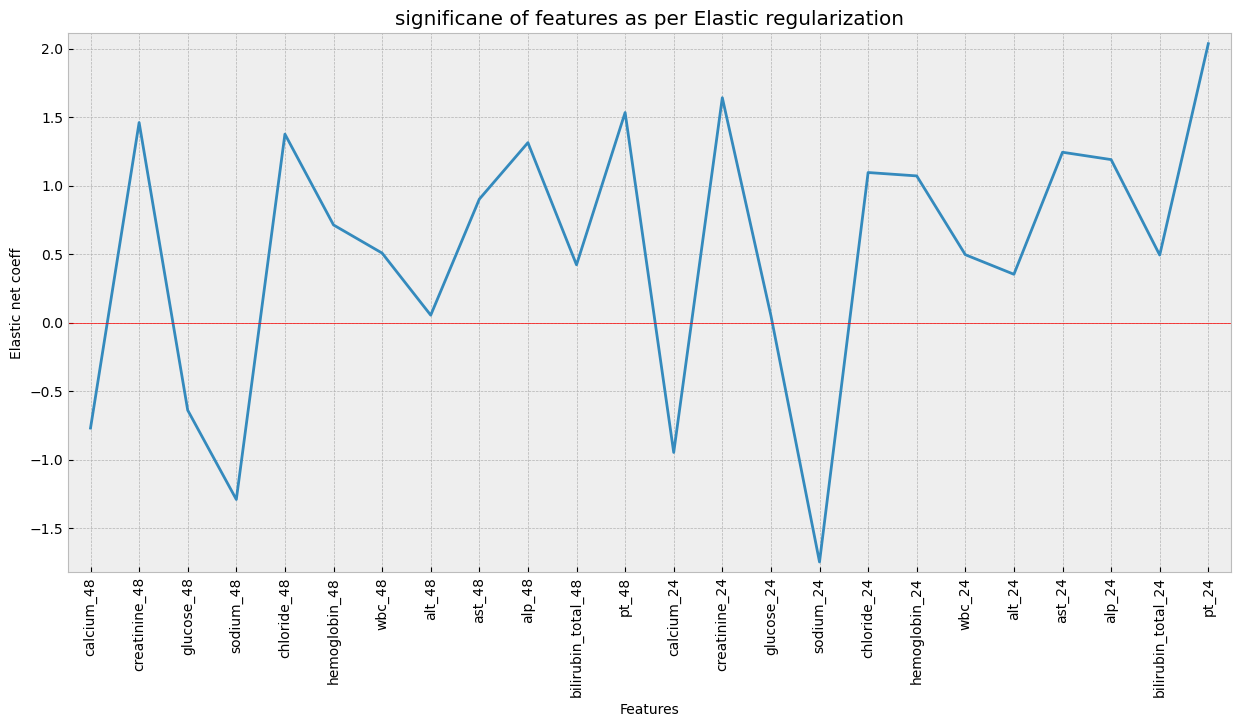

<Figure size 500x500 with 0 Axes>

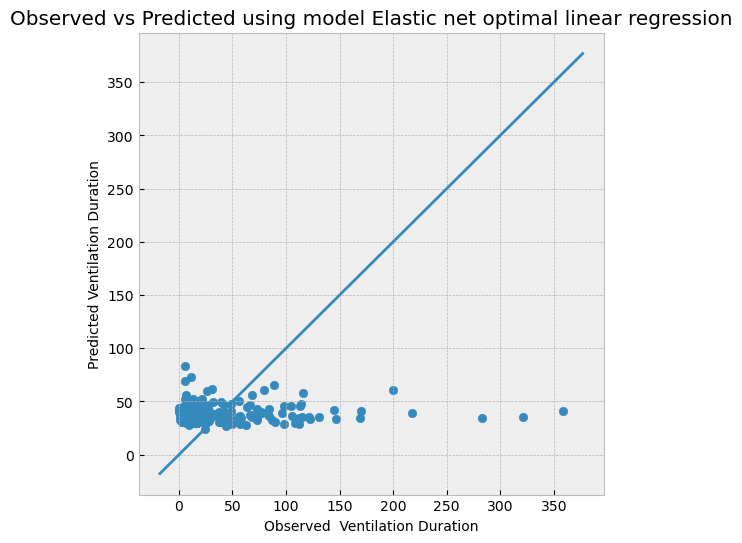

In [185]:
# Fitting, tuning and predicting using the best elastic net regression model
import warnings  
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test, elastic_net_opt = trend_model(data=data, cols_to_transform=cols_to_transform, 
                                                                l1_space=l1_space, alpha_space=alpha_space,
                                                                scale = True, test_size = 0.15, include_test_scale=True)

In [187]:
# printing the error metrics
print('Elastic net regression on training set')
error_metrics(elastic_net_opt.predict(X_train), y_train, model_name = 'Tuned elastic net regression with reduced hour space', 
              test = False)

print('\nElastic net regression on test set')
error_metrics(elastic_net_opt.predict(X_test), y_test, model_name = 'Tuned elastic net regression with reduced hour space', 
              test = True)

Elastic net regression on training set

Error metrics for model Tuned elastic net regression with reduced hour space
SMAE or Symmetric Mean Absolute Error: 41.25
MSE or Mean squared error: 2983.42
RMSE or Root mean squared error: 54.62
R2 score: 0.04
Mean Absolute Error: 31.47
Mean Absolute Percentage Error: 574.19 %

Elastic net regression on test set

Error metrics for model Tuned elastic net regression with reduced hour space
SMAE or Symmetric Mean Absolute Error: 41.80
MSE or Mean squared error: 2057.22
RMSE or Root mean squared error: 45.36
R2 score: 0.00
Mean Absolute Error: 29.26
Mean Absolute Percentage Error: 452.42 %
